In [3]:
import os, sys

codepath = '/user_data/mmhender/image_stats_gabor/code/'
sys.path.insert(0,codepath)

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm

import pandas as pd

from plotting import plot_utils
from model_fitting import initialize_fitting 
from utils import numpy_utils, default_paths, prf_utils


In [4]:
# Load everything

subject=998;
# subject=999; # 999 is our independent set of 10,000 COCO images
feature_type='gabor_solo'
which_prf_grid=5

path_to_load = default_paths.gabor_texture_feat_path
path_to_load = os.path.join(path_to_load, 'feature_decoding')
    
fn1 = os.path.join(path_to_load, 'S%d_%s_LDA_categ_all_grid%d_matchprfs.npy'%(subject, feature_type, which_prf_grid))
print(fn1)
decoding = np.load(fn1,allow_pickle=True).item()
    
names = [n.split('categ_')[1] for n in decoding['discrim_type_list']]
acc = decoding['acc']
dprime = decoding['dprime']

n_axes = len(names)

prfs_use = acc[:,0]!=0
assert(np.all(prfs_use==prf_utils.get_prfs_use_decoding()))

/user_data/mmhender/features/gabor_texture/feature_decoding/S998_gabor_solo_LDA_categ_all_grid5_matchprfs.npy


In [5]:
names

['face',
 'building',
 'animate',
 'inanimate',
 'small',
 'large',
 'indoor',
 'outdoor']

In [6]:
assert(which_prf_grid==5)
models = prf_utils.get_prf_models(which_grid=which_prf_grid)
n_prfs = len(models)

x = models[:,0]*8.4; y = models[:,1]*8.4;
ecc = np.round(np.sqrt(models[:,0]**2+models[:,1]**2)*8.4, 4)
sizes = np.round(models[:,2]*8.4, 4)
angles = np.round(np.mod(np.arctan2(y,x)*180/np.pi, 360),1)

ecc_vals = np.unique(ecc)
size_vals = np.unique(sizes)
n_ecc = len(ecc_vals);
n_sizes = len(size_vals)
n_angles = len(np.unique(angles))

sizes_use = [size_vals[5]]
sizes_use

[1.4763]

#### Analyze the slopes
(this is slow to run, uses permutation test)

In [7]:
import scipy
pars = [sizes, ecc, y, x]
n_pars = len(pars)
par_names = ['size', 'eccen','ypos', 'xpos']

n_iter = 10000
slope_values = np.zeros((n_axes, n_pars), dtype=float)
slope_values_shuffle = np.zeros((n_axes, n_pars, n_iter), dtype=float)

inter_values = np.zeros((n_axes, n_pars), dtype=float)
r_values = np.zeros((n_axes, n_pars), dtype=float)
p_values_parametric = np.zeros((n_axes,n_pars), dtype=float)

rndseed = 234325
np.random.seed(rndseed)

for ai in range(n_axes):

    for pi, par in enumerate(pars):
        
        print('%s, %s'%(names[ai], par_names[pi]))

        if pi==0:
            prf_inds = prfs_use
        else:
            prf_inds = (prfs_use & (np.isin(sizes, sizes_use)))

        x_vals = par[prf_inds]

        vals = dprime[prf_inds,ai]

        reg_result = scipy.stats.linregress(x_vals, vals)

        slope_values[ai,pi] = reg_result.slope
        inter_values[ai,pi] = reg_result.intercept
        r_values[ai,pi] = reg_result.rvalue
        p_values_parametric[ai,pi] = reg_result.pvalue

        # permutation test to get a non-parametric p-value
        for xx in range(n_iter):

            shuff_order = np.random.permutation(np.arange(len(x_vals)))
            shuff_x_vals = x_vals[shuff_order]
            reg_result = scipy.stats.linregress(shuff_x_vals, vals)
            slope_values_shuffle[ai,pi,xx] = reg_result.slope

face, size
face, eccen
face, ypos
face, xpos
building, size
building, eccen
building, ypos
building, xpos
animate, size
animate, eccen
animate, ypos
animate, xpos
inanimate, size
inanimate, eccen
inanimate, ypos
inanimate, xpos
small, size
small, eccen
small, ypos
small, xpos
large, size
large, eccen
large, ypos
large, xpos
indoor, size
indoor, eccen
indoor, ypos
indoor, xpos
outdoor, size
outdoor, eccen
outdoor, ypos
outdoor, xpos


In [8]:
import statsmodels
from utils import stats_utils

# compute a two-tailed p-value here:
p_values = np.minimum(np.mean(slope_values_shuffle<=slope_values[:,:,np.newaxis], axis=2), \
                      np.mean(slope_values_shuffle>=slope_values[:,:,np.newaxis], axis=2))*2
# FDR correction
mask_fdr, pvals_fdr = \
    stats_utils.fdr_keepshape(p_values, alpha=0.01)


In [9]:
par_names = ['size', 'eccen','ypos', 'xpos']

slopes_table = pd.DataFrame({}, index=names)
for pi in range(n_pars):
    slopes_table['%s slope'%par_names[pi]] = slope_values[:,pi]
    slopes_table['%s fdr sig'%par_names[pi]] = mask_fdr[:,pi]

slopes_table

,size slope,size fdr sig,eccen slope,eccen fdr sig,ypos slope,ypos fdr sig,xpos slope,xpos fdr sig
face,-0.008528,True,-0.014315,True,-0.015424,True,-0.003398,False
building,-0.000205,False,0.003031,False,-0.035709,True,-0.006969,False
animate,-0.005162,True,-0.026281,True,0.003363,False,0.000119,False
inanimate,0.032847,True,-0.013457,False,-0.045953,True,-0.003593,False
small,0.021120,True,-0.023136,True,-0.024495,True,-0.004370,False
large,-0.001174,False,-0.011937,True,-0.001670,False,0.000531,False
indoor,0.032193,True,0.028885,True,-0.004971,False,-0.000984,False
outdoor,0.034916,True,0.026697,True,-0.012900,True,-0.000978,False


In [10]:
colors = np.concatenate([np.flipud(cm.Purples(np.linspace(0,1,5)))[1:3,:], \
                        np.flipud(cm.Reds(np.linspace(0,1,5)))[1:3,:], \
                        np.flipud(cm.Blues(np.linspace(0,1,5)))[1:3,:], \
                        np.flipud(cm.Greens(np.linspace(0,1,5)))[1:3,:]])

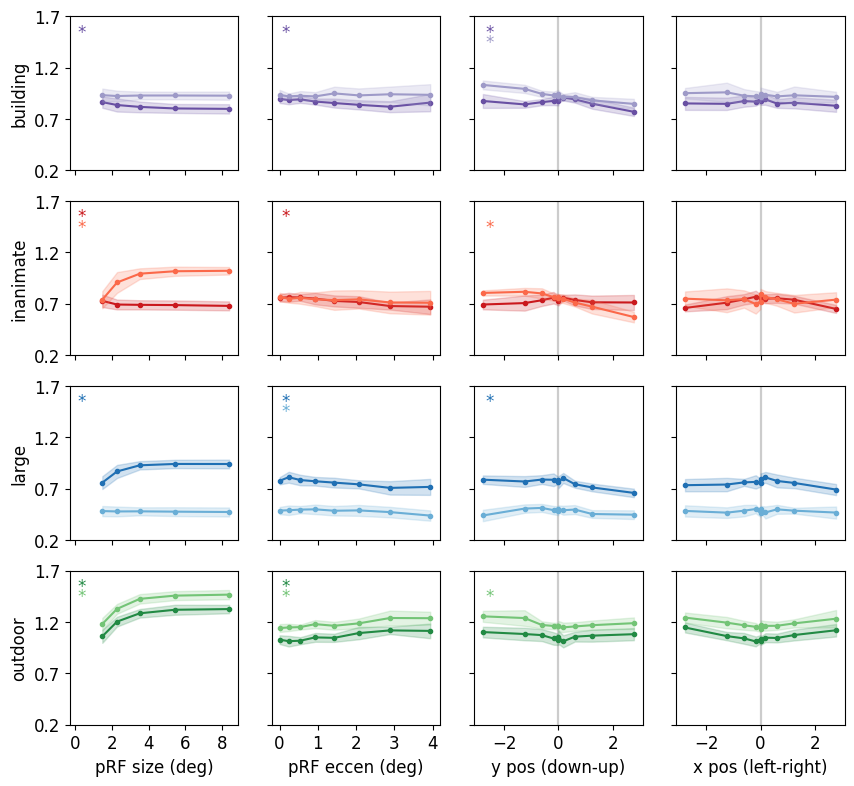

In [11]:
import scipy

sizes_use = [size_vals[5]]

plt.figure(figsize=(10,9.2));
plot_utils.set_all_font_sizes(12)
plt.rcParams['pdf.fonttype']=42

axes_plot = np.arange(8)

plot_inds = [(np.arange(4)+ii).astype(int) for ii in [1,1,5,5,9,9,13,13]]
plot_inds = np.array(plot_inds).ravel()

# npx = len(axes_plot)
npx = 4;

n_bins=10
linear_bins=False

ylims = [0.2, 1.7];
annot_ylocs = [1.4, 1.5]

yticks = np.linspace(ylims[0], ylims[1], 4)

xticks = [[0,2,4,6,8], [0,1,2,3,4], [-2, 0, 2], [-2, 0, 2]]
xlims = [[-0.3,8.9],[-0.2, 4.2],[-3.1,3.1],[-3.1,3.1]]

par_names = ['pRF size (deg)', 'pRF eccen (deg)', 'y pos (down-up)', 'x pos (left-right)']

annot_xlocs = [0.1,0.05,-2.7,-2.7]

# annot_xlocs = [0.4,0.2,-2.3,-2.3]
    
pi=0;

for ai in axes_plot:

    name = names[ai]

    for par_ind, par in enumerate(pars):

        pi+=1
        plt.subplot(npx,4,plot_inds[pi-1])

        if par_ind==0:
            prf_inds = prfs_use
        else:
            prf_inds = (prfs_use & (np.isin(sizes, sizes_use)))

        x_vals = par[prf_inds]
        vals = dprime[prf_inds,ai]

        # plt.plot(x_vals, vals, '.', color=[0.8, 0.8, 0.8, 1])
        if par_ind>1:
            xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(x_vals, vals, n_bins=n_bins, \
                                            linear_bins=linear_bins, return_std=True)  
        else:
            xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(x_vals, vals, n_bins=n_bins, \
                                                linear_bins=linear_bins, return_std=True, \
                                                                use_unique=True)    
        plt.plot(xbinned, ybinned, '.-',color=colors[ai,:] ,zorder=10)
        plt.fill_between(xbinned, ybinned-ystd, ybinned+ystd,
                alpha=0.2, edgecolor=colors[ai,:], facecolor=colors[ai,:], zorder=10)

        if ai>5:
            plt.xlabel(par_names[par_ind])
            plt.xticks(xticks[par_ind])
        else:
            plt.xticks(xticks[par_ind], labels=[])
        if par_ind==0:
            plt.ylabel(name)
            plt.yticks(yticks)
        else:
            plt.yticks(yticks,[])
        plt.ylim(ylims)
        plt.xlim(xlims[par_ind])

        # print(ai, par_ind)
        # print(mask_fdr[ai,par_ind])
        # rho, p = scipy.stats.pearsonr(x_vals, vals)
        # plt.title('rho=%.2f, p=%.4f'%(rho, p))
        if mask_fdr[ai, par_ind]:
            if np.mod(ai,2):
                annot_yloc=annot_ylocs[0]
            else:
                annot_yloc=annot_ylocs[1]
            plt.annotate('*',(annot_xlocs[par_ind],annot_yloc),color=colors[ai,:])

        if par_ind>1:
            plt.axvline(0, color=[0.8, 0.8, 0.8])

        # plt.axhline(0, linestyle='--',color=[0.8, 0.8, 0.8, 1])
        
fn2save = fn2save = os.path.join(default_paths.fig_path,'decode_categ_all.pdf')
plt.savefig(fn2save)